# Clustering con algoritmo K-means

El objetivo general de los métodos de clustering es agrupar los datos en conjuntos (clusters) tal que:

- Los elementos dentro de un mismo cluster sean similares
- Los elementos dentro de un mismo cluster sean distintos a los elementos pertenecientes a otro cluster

:::{important}

Los métodos de clustering permiten revelar estructuras escondidas en los datos y son muy importantes para realizar análisis exploratorio de datos.

:::

En general, los algoritmos de clustering requieren definir un criterio para medir similitud entre los ejemplos. Lo más típico para datos numéricos es usar métricas de distancia como la [distancia euclidiana](https://es.wikipedia.org/wiki/Distancia_euclidiana) o la [distancia de manhattan/taxista](https://es.wikipedia.org/wiki/Geometr%C3%ADa_del_taxista).

Una vez definida la noción de distancia a utilizar se debe definir un criterio de agrupación. Dependiendo de la combinación entre estas definiciones surgen distintas familias de algoritmos de clustering.

- Algoritmos basados en representantes (centroides)
- Algoritmos basados en conectividad y jerarquías
- Algoritmos basados en modelos de densidad

En esta lección nos enfocaremos en un algoritmo clásico de clustering basado en representantes: K-medias o *K-means*. 

## Formalismo matemático

El algoritmo de K-means requiere que el usuario especifique a priori el número de clusters a detectar, es decir que $K$, el número de clusters es un hiperparámetro del algoritmo. El algoritmo K-means es bastante simple y se resume en el siguiente diagrama esquemático.

<img src="img/kmeans.png" width="700">

Detalles:

- Los centroides $\{c_j\}_{j=1,\ldots,K}$ son los centros de los clusters. 
- En el paso 2, el cluster asociado a la muestra $i$ se calcula usando la distancia euclidiana

$$
\begin{align}
y_i &= \text{arg}\min_{j=1,\ldots,K} \| x_i - c_j\|_2^2  \nonumber \\
&= \text{arg}\min_{j=1,\ldots,K} \sqrt{ \sum_{d=1}^D (x_{id} - c_{jd})^2}  \nonumber 
\end{align}
$$

- En el paso 3 los el centroide $j$ se actualiza como

$$
c_j = \frac{\sum_{i=1}^N \mathbb{1}(y_i = j) x_i}{\sum_{i=1}^N \mathbb{1}(y_i = j)}
$$

donde la función indicadora se define como

$$
\mathbb{1}(y_i = j) = \begin{cases} 1 & \text{si } y_i = j \\ 0 & \text{si } y_i \neq j \end{cases}
$$

es decir que el centroide es el promedio de las muestras asociadas a si mismo



## K-means con `scikit-learn`

K-means está incluido en el módulo [`sklearn.cluster`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.cluster). El constructor y sus argumentos más importantes son:

```python
KMeans(n_clusters=8, # El número de grupos/clusters
       init='k-means++', #El algoritmo de inicialización puede ser random o k-means++
       n_init=10, # El número de inicializaciones que se prueban
       max_iter=300, # El número máximo de iteraciones
       tol=0.0001, # Si la diferencia entre los centroides en distintas iteraciones es menor que este valor, el algoritmo se detiene
       ...
      )
```

Los métodos más importantes de la clase [`KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) son:

- `fit(X)`: Entrena y obtiene los centroides
- `predict(X)`: Retorna el índice del cluster más cercano para cada dato
- `fit_predict(X)`: `fit` y `predict` en un solo paso

Los atributos más importantes son:

- `cluster_centers_`: Los centroides de los clusters
- `inertia_`: La suma de errores cuadrados

**Ejemplo:** 

A modo de ejemplo se realiza un clustering con KMeans sobre el dataset Iris. 

Para escoger el mejor número de clusters se utiliza el [coeficiente de silueta](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html).

In [1]:
from sklearn.datasets import load_iris

iris_set = load_iris()
X, y, y_names = iris_set['data'], iris_set['target'], iris_set['target_names']

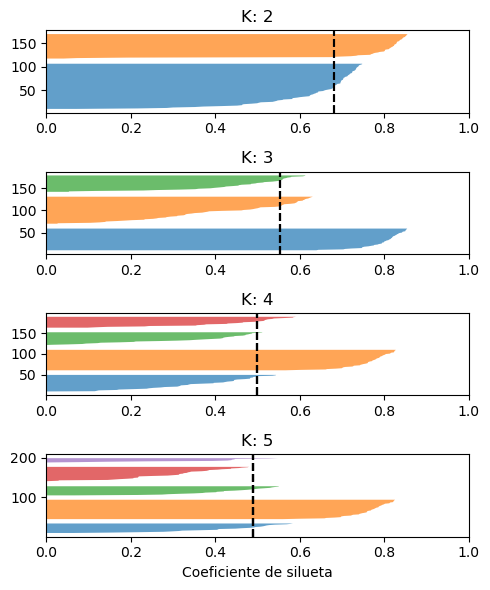

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans

fig, ax = plt.subplots(4, 1, figsize=(5, 6), tight_layout=True)

for k, n_clusters in enumerate(range(2, 6)):
    # Clustering con kmeans
    kmeans = KMeans(n_clusters=n_clusters, n_init=10)
    membership = kmeans.fit_predict(X)
    # Score de silueta promedio y por ejemplo
    score_promedio = silhouette_score(X, membership)
    score_ejemplos = silhouette_samples(X, membership)
    y_lower = 10
    for cluster in np.unique(membership):  
        scores_cluster_sorted = np.sort(score_ejemplos[membership==cluster])
        y_upper = y_lower + len(scores_cluster_sorted)
        ax[k].fill_betweenx(np.arange(y_lower, y_upper), 0, scores_cluster_sorted, alpha=0.7)
        ax[k].axvline(score_promedio, ls='--', c='k')
        ax[k].set_title(f'K: {n_clusters}')
        ax[k].set_xlim([0, 1])
        y_lower = y_upper + 10
    ax[-1].set_xlabel('Coeficiente de silueta')

Las figuras muestran los coeficientes de silueta de los ejemplos asociados a cada uno de los clusters. La linea punteada negra corresponde al coeficiente de silueta promedio. 

Tanto el caso de $K=4$ como $K=5$ presentan algunos clusters cuyos coeficientes de silueta son menores que el promedio. Por otro lado el caso $K=2$ presenta alta disparidad en el tamaño de los clusters. En el caso $K=3$ los clusters son de un tamaño más uniforme y todos los clusters tienen ejemplos que superan el coeficiente promedio.

Otra forma de guiar la selección del número de clusters es visualizar el decaimiento de la función de costo (suma de errores cuadráticos) en función del número de clusters 

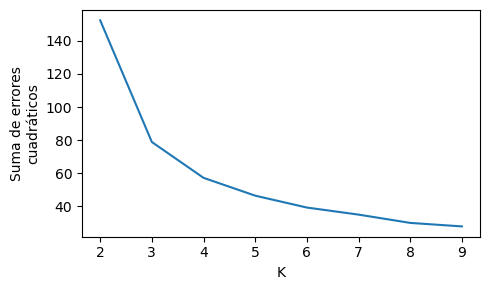

In [3]:
sse = []
n_clusters_test = range(2, 10)
for n_clusters in n_clusters_test:
    kmeans = KMeans(n_clusters=n_clusters, n_init=10)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)
    
fig, ax = plt.subplots(figsize=(5, 3), tight_layout=True)
ax.plot(n_clusters_test, sse)
ax.set_ylabel('Suma de errores\ncuadráticos')
ax.set_xlabel('K');

En este caso el mayor decaimiento en error cuadrático ocurre cuando pasamos de $K=2$ a $K=3$, lo cual indica que $K=3$ es una buena elección.

:::{note}

En este caso particular el dataset tiene tres clases y el mejor número de clusters coincide con esta cantidad.

:::

A continuación se muestran las clases originales versus las agrupaciones encontradas por K-means sobre la proyección a dos dimensiones obtenida con PCA.

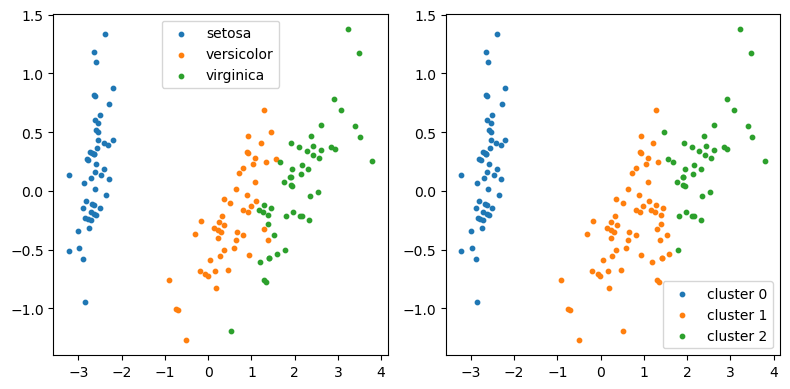

In [4]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
hatX = pca.fit_transform(X)
kmeans = KMeans(n_clusters=3, n_init=10)
membership = kmeans.fit_predict(X)

fig, ax = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True)
for y_, name in enumerate(y_names):
    ax[0].scatter(hatX[y==y_, 0], hatX[y==y_, 1], s=10, label=name)
ax[0].legend()

for c in np.unique(membership):
    ax[1].scatter(hatX[membership==c, 0], hatX[membership==c, 1], s=10, label=f'cluster {c}')
ax[1].legend();

## Detalles prácticos sobre K-means

La correctitud de los clusters depende fuertemente de $K$. Se recomienda probar con distinto $K$ y evaluar los resultados usando el método del codo o el coeficiente de silueta. 

El algoritmo de K-means es sensible a los centroides iniciales. Por lo tanto es recomendable probar varias veces con distintas inicializaciones. Por defecto `KMeans` prueba 10 inicializaciones distintas. Esto se puede controlar con el argumento `n_init`.

K-means es un algoritmo rápido y que escala bien a datos masivos. Scikit-learn ofrece [`MinibatchKMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html) para esos casos.

**Variantes de K-means**

Si los datos tiene outliers fuertes se puede reemplazar el promedio en el paso 3 de KMeans por la mediana, obteníendose el algoritmo de las k-medianas.

Si es un requisito que los centroides sean siempre ejemplos del dataset se puede usar el algoritmo de los [k-medoides](https://es.wikipedia.org/wiki/K-medoids).

**Debilidades de KMeans**

K-means asume que los clusters son:

- de "forma esférica" 
- de igual densidad. 

:::{seealso}

Si lo anterior no se cumple puede ser mejor utilizar algoritmos más generales (y más costosos) como [Modelos de mezcla de gaussianas](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.mixture) o [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html#sklearn.cluster.DBSCAN).

:::

